In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
import re
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression as LR


f = open("clasificados_2.txt", "r", encoding="utf-8")
fg = open("pruebas.txt", "r", encoding="utf-8")

# Pruebas
pruebas = fg.read()
pruebas_x = re.split('\nGolden label: -*[01]\n', pruebas)
pruebas_x.pop()
#golden_y es una variable auxiliar
y_test = []
golden_y = re.findall('Golden label: -*[01]', pruebas)
for x in golden_y:
    y_test.append(re.split('Golden label: ', x)[1])

#Entrenamiento, con el documento con etiquetados
texto_completo = f.read()
train_x = re.split('\nGolden label: -*[01]\n', texto_completo)
train_x.pop()
y_train = []
golden_y = re.findall('Golden label: -*[01]', texto_completo)
for x in golden_y:
    y_train.append(re.split('Golden label: ', x)[1])

#Extraemos ahora los documentos sin etiquetar(tweets que no han sido clasif)
f = open("no_clasificados.txt", "r", encoding="utf-8")
texto_completo = f.read()
sin_clasificar = re.split(r'\n<\\s>\n', texto_completo)
sin_clasificar.pop()

#Unimos los tweets sin clasificar con train_x para tener un vector de todos los
#tweets (hasta ahora, son alrededor de 5000 tweets)

for x in train_x:
    sin_clasificar.append(x)
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5)
X_train2 = vectorizer.fit_transform(sin_clasificar)

X_test2 = vectorizer.transform(pruebas_x)
sin_clasificar = sin_clasificar[:538]
# vectorizer es el vector tfidf de todos los datos.
#parametro max_df=0.9: si una palabra aparece mas del 90% de los documentos,
#la ignoramos (reducir parametros = reducir dimensionvc)
#parametro min_df=16: si una palabra aparece en menos de 16 documentos, la
#ignoramos tambien. Al final, con estos datos obtenemos una matriz de
#sparse de 805 caracteristicas (o parametros)
X_train = vectorizer.fit_transform(sin_clasificar)

X_test = vectorizer.transform(pruebas_x)

target_names = ['1', '0', '-1']

feature_names = vectorizer.get_feature_names()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()

    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
        #    print("top 10 keywords per class:")
        #    for i, label in enumerate(target_names):
        #        top10 = np.argsort(clf.coef_[i])[-10:]
        #        print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        #print()

    #if opts.print_report:
    #    print("classification report:")
    #    print(metrics.classification_report(y_test, pred,
    #                                        target_names=target_names))

    #if opts.print_cm:
    #    print("confusion matrix:")
    #    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.028s
test time:  0.000s
accuracy:   0.287
dimensionality: 340
density: 1.000000

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.009s
test time:  0.000s
accuracy:   0.337
dimensionality: 340
density: 1.000000

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, 

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.404s
test time:  0.012s
accuracy:   0.287

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.007s
test time:  0.001s
accuracy:   0.347
dimensionality: 340
density: 1.000000

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.012s
test time:  0.000s
a

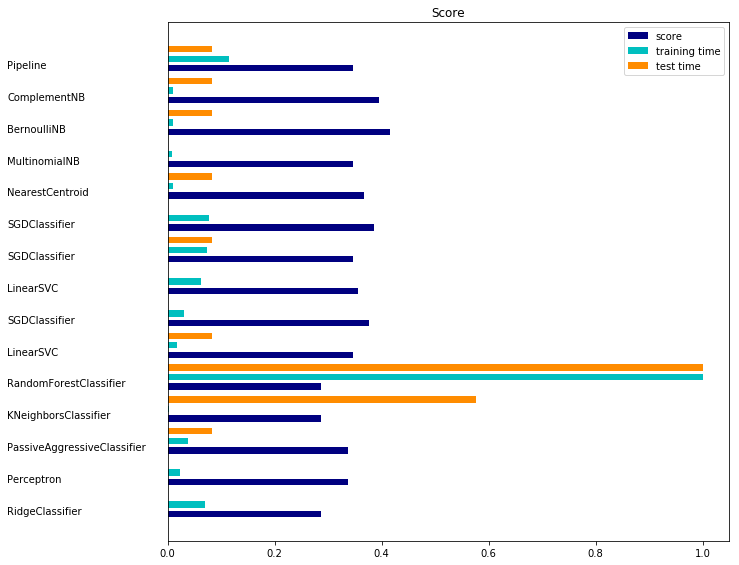

In [24]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")

results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [83]:
reduced_data = PCA(n_components=2).fit_transform(X_train2.toarray())
kmeans = KMeans(n_clusters=3)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

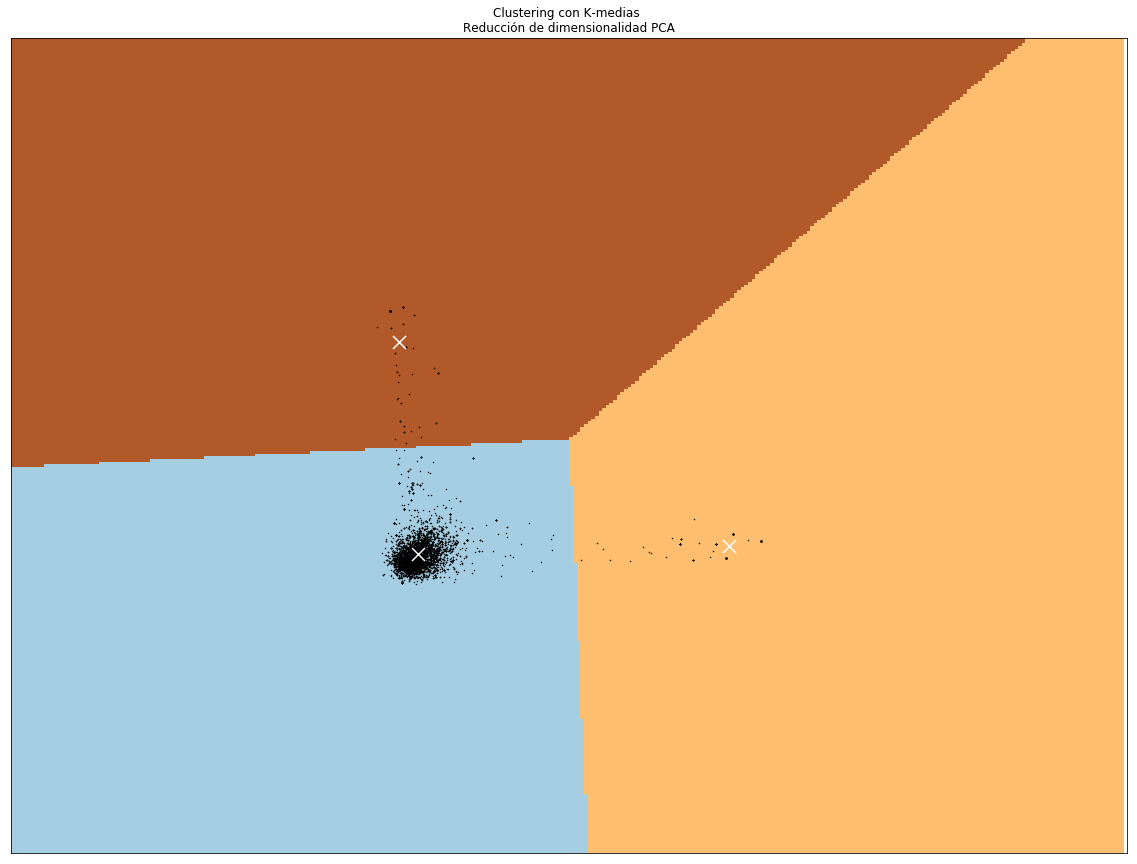

In [84]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01   # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(20,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering con K-medias \nReducción de dimensionalidad PCA')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [4]:
clf = LR(multi_class="ovr", solver="liblinear").fit(X_train, y_train)


ValueError: Found input variables with inconsistent numbers of samples: [538, 1056]